<a href="https://www.kaggle.com/code/alekseyschukin/oil-wells?scriptVersionId=162647589" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import xgboost as xgb
import random

import pickle

from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.preprocessing import RobustScaler,minmax_scale,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,GroupKFold,StratifiedKFold,StratifiedGroupKFold
from sklearn.metrics import classification_report, mean_squared_error as MSE,roc_auc_score,confusion_matrix,f1_score,ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **Введение.**

  Анализ данных показал необходимость разделения скважин на разные датасеты с различным набором признаков. Для каждого датасета нужно построить индивидуальные модели. Учитывая ограниченный опыт в работе с временными рядами, предпочтение было отдано классическим методам машинного обучения. Однако, интерес к данной области остается, и при наличие времени планируется дальнейшее исследование данного набора данных.

   **Спасибо Вам за предоставленные данные. Ожидается обратная связь и рекомендации по проделанной работе.**

### **1. Описание  набора данных**

Информация о датасете
В .csv файле хранятся данные геофизических исследований (https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D1%80%D0%BE%D1%82%D0%B0%D0%B6) для набора скважин
Колонка 'WELLNAME' соответствует названию скажины (ID временного ряда)

Колонка 'DEPT' глубина измерения сигнала, м (аналог времени)

Колонка 'target' - разметка сегментов временного ряда

Колонки 'DENS' и 'DEN' - плотностной каротаж, g/cm3

Колонки 'DT' и 'SONIC' - кривые акустического каротажа, us/ft

Колонки 'FLGR' и 'GR' - гамма-каротаж (измерения радиоактивных свойств пород), gAPI

Колонки 'CALI' и 'CAL' - измерение размера скважины вдоль ствола, inches

Колонки 'RESD' и 'RES_DEP' - кривые электрического сопротивления, ohm*m

*однотипные картоажные данные отличаются измерительными приборами, с помощью которых проводились исследования

In [2]:
df1 = pd.read_csv('/kaggle/input/test-df/groningen_test.csv')
df1.head()

,DEPT,DENS,DEN,DT,SON,FLGR,GR,CALI,CAL,RESD,RES_DEP,WELLNAME,target
0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,AMR-1,NaN
1,0.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,AMR-1,NaN
2,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,AMR-1,NaN
3,1.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,AMR-1,NaN
4,2.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,AMR-1,NaN


<Axes: >

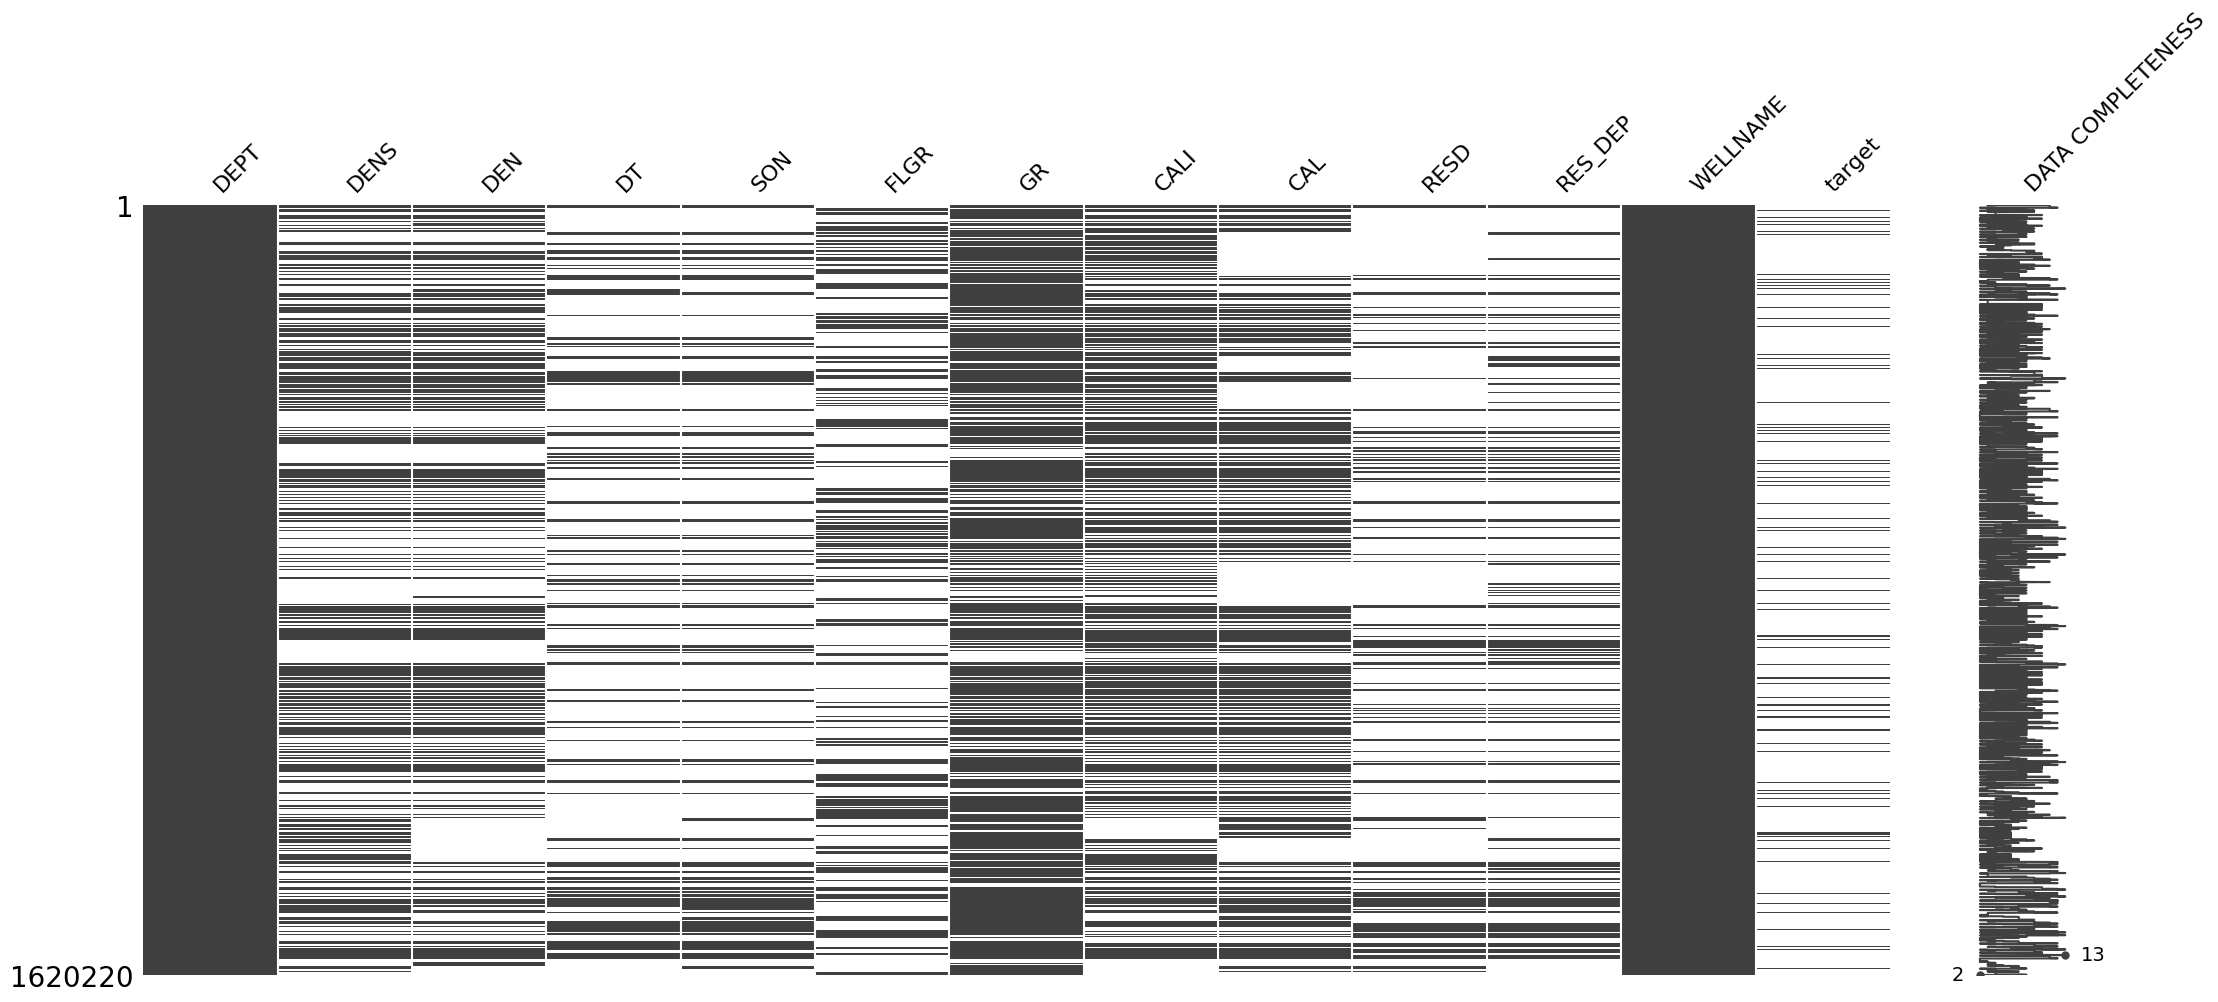

In [3]:
msno.matrix(df1, labels=True)


In [4]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
DEPT,1620220.0,1754.147744,872.776812,0.000000,1054.400033,1889.320154,2459.508148,4649.987202
DENS,747617.0,2.276505,0.262962,0.974000,2.085185,2.151256,2.488000,3.129130
DEN,689497.0,-1.206745,186.560597,-9999.000000,2.084000,2.150000,2.483999,3.100694
DT,381899.0,88.948730,32.671687,15.766000,68.154129,76.667244,95.651283,818.229980
SON,397839.0,88.782977,32.524313,15.766000,68.173908,76.603462,95.401955,818.229980
FLGR,561170.0,0.302290,0.459200,0.000000,0.000000,0.000000,1.000000,1.000000
GR,1218378.0,33.471632,32.789365,-2.427295,11.023840,19.045359,46.150964,686.233398
CALI,938292.0,11.538250,3.541366,-0.080793,9.878000,10.416748,12.103077,36.213814
CAL,775905.0,11.626421,3.516136,-0.080793,9.872221,10.450734,12.325281,40.175247
RESD,341835.0,1686.824420,5620.062118,-0.144000,1.260508,5.401033,1413.899475,99739.312500


In [5]:
((df1.DEN/df1.DENS)).value_counts()

1.0    668927
Name: count, dtype: int64

In [6]:
df1[df1.DEN==df1.DEN.min()].head(2)
df1.replace(-9999.0,np.NaN,inplace = True)
df1.replace(df1['RES_DEP'].max(),np.NaN,inplace = True)
names = df1.WELLNAME.unique()


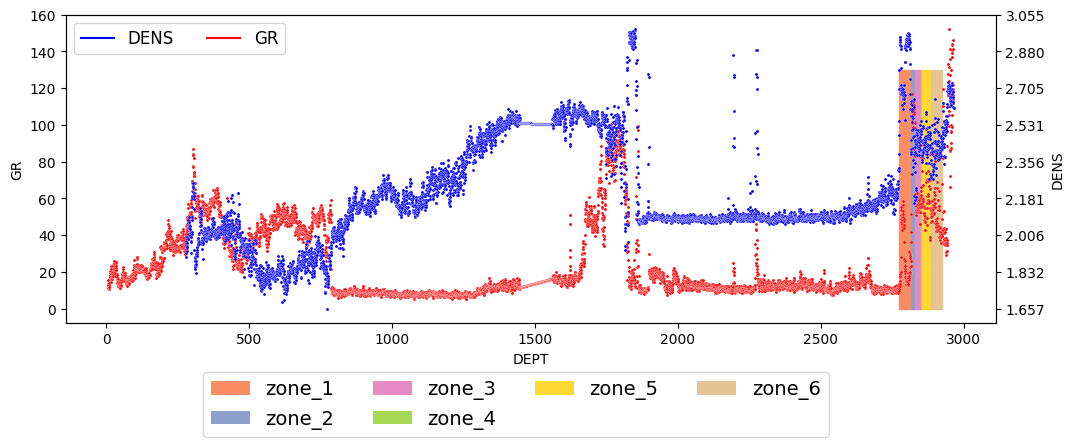

In [7]:

name = names[0]
fig, axn = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 4))

well = df1[df1.WELLNAME == name]
for i in range(len(well.target.unique())):
    if well.target.unique()[i] is not None:
        start_depth = well[well.target == well.target.unique()[i]]['DEPT'].min()
        end_depth = well[well.target == well.target.unique()[i]]['DEPT'].max()
        axn.fill_between(
            [start_depth, end_depth], [0,0], [130,130],
            color = sns.color_palette('Set2', 9)[i]
        )

axn.set(xlabel = None)

ax1 = axn.twinx()
sns.scatterplot(
    data=df1[df1.WELLNAME == name], x='DEPT', y='GR',ax=axn, color='red', s=5   
)
sns.scatterplot(
    data=df1[df1.WELLNAME == name], x='DEPT', y='DENS', ax=ax1, color='blue', s=5
)

ylim1 = axn.get_ylim()
len1 = ylim1[1]-ylim1[0]
yticks1 = axn.get_yticks()
rel_dist = [(y-ylim1[0])/len1 for y in yticks1]
ylim2 = ax1.get_ylim()
len2 = ylim2[1]-ylim2[0]
yticks2 = [ry*len2+ylim2[0] for ry in rel_dist]

ax1.set_yticks(yticks2)
ax1.set_ylim(ylim2)

axn.legend(handles=[
    Line2D([], [], marker='', color='blue', label='DENS'),
    Line2D([], [], marker='', color='red', label='GR')
], fontsize = 12, ncol = 2)



legend_elements = [Patch(facecolor = sns.color_palette('Set2', 9)[i], label = f'zone_{i}') for i in range(len(well.target.unique()))]

fig.legend(handles = legend_elements[1:], loc ='lower center', fontsize = 14,
            bbox_to_anchor = (0, -0.2, 1, 1) ,ncol = 4)

In [8]:
print('DENS-DEN = ',(df1.DENS-df1.DEN).sum())
print('')
print('DEN/DENS =' ,(df1.DEN/df1.DENS).value_counts())
print('')
display(df1.isna().sum())

DENS-DEN =  0.0

DEN/DENS = 1.0    668927
Name: count, dtype: int64



DEPT              0
DENS         872603
DEN          930963
DT          1238321
SON         1222381
FLGR        1059050
GR           401842
CALI         681928
CAL          844315
RESD        1278385
RES_DEP     1214764
WELLNAME          0
target      1463260
dtype: int64

Мы видим, что **измерения сделанные разными датчиками одинаковые**, единственная разница - это только в количестве пропущенных значениях.

In [9]:
df = df1[['DEPT','target','WELLNAME','FLGR','GR']]

In [10]:
df['DEN'] = df1[['DENS','DEN']].mean(axis=1)
df['DT'] = df1[['DT','SON']].mean(axis=1)
df['CAL'] = df1[['CALI','CAL']].mean(axis=1)
df['RESD'] = df1[['RESD','RES_DEP']].mean(axis=1)

Не увидив разницу между измерениями датчика,  я решил их усреднить , тем самым избавиться от нескольких пропусках в  измерениях. Я пока не знаю как это повлияет на результат , но все дальнейшие действия буду проводить с новым датасетом. Конечно, обратная связь от компании или более обширное описание датасета пошло бы на пользу. Но в нашем случае, мы просто продолжаем идти дальше.

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DEPT,1620220.0,1754.147744,872.776812,0.000000,1054.400033,1889.320154,2459.508148,4649.987202
FLGR,561170.0,0.302290,0.459200,0.000000,0.000000,0.000000,1.000000,1.000000
GR,1218378.0,33.471632,32.789365,-2.427295,11.023840,19.045359,46.150964,686.233398
DEN,767947.0,2.276262,0.262812,0.974000,2.085000,2.151044,2.488703,3.129130
DT,405516.0,88.842549,32.586743,15.766000,68.173208,76.635460,95.484833,818.229980
CAL,992056.0,11.686494,3.707527,-0.080793,9.891000,10.458820,12.250964,40.175247
RESD,425411.0,1586.014945,5115.491082,-0.144000,1.478783,7.399215,1560.883484,99739.312500


### **2. Проведем небольшой дата анализ**

In [12]:
def range_col(x):
    return x.max() - x.min()
df_1 = df.groupby(['WELLNAME','target',]).agg({'DEPT': ['min','max',range_col]}).reset_index()


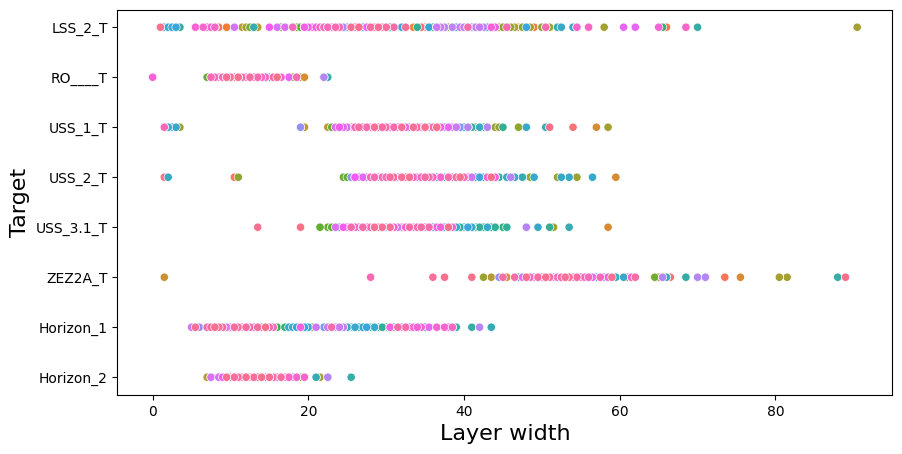

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = df_1, x=('DEPT', 'range_col'), y = ('target', ''),hue = ('WELLNAME', ''),)
plt.xlabel('Layer width',fontsize = 16)
plt.ylabel('Target',fontsize = 16)
ax.legend_.remove()

plt.show()

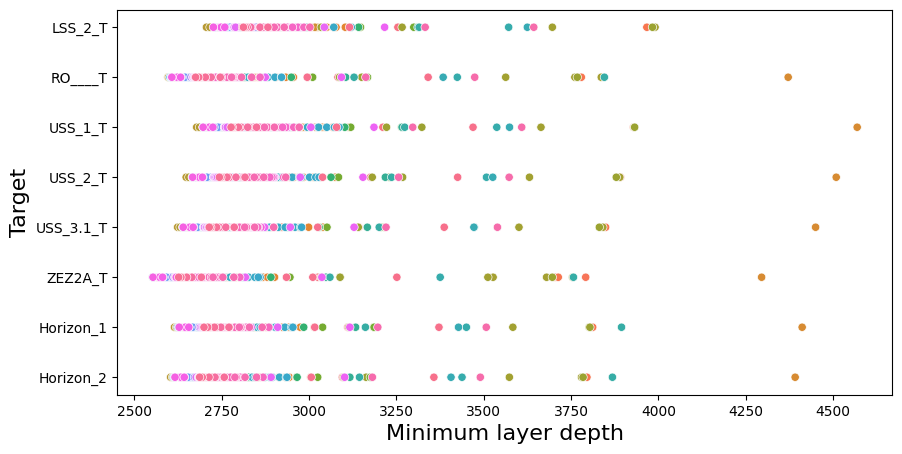

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = df_1, x=('DEPT', 'min'), y = ('target', ''),hue = ('WELLNAME', ''))
ax.legend_.remove()
plt.xlabel('Minimum layer depth',fontsize = 16)
plt.ylabel('Target',fontsize = 16)
plt.show()

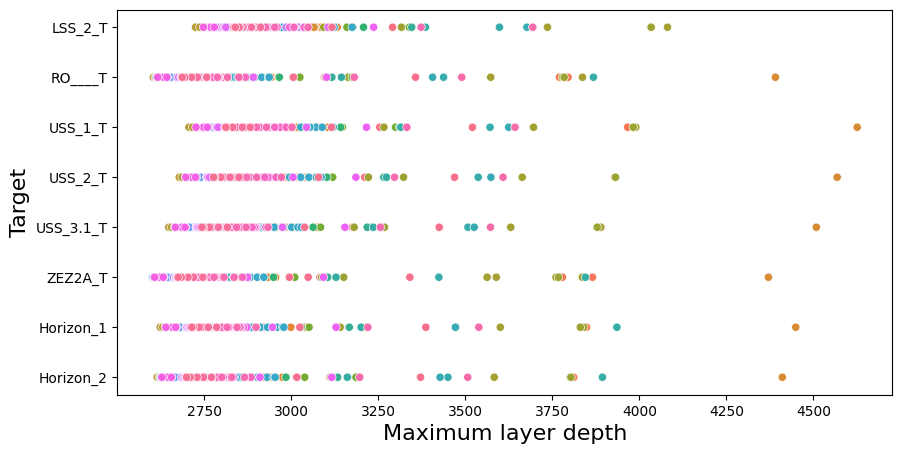

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = df_1, x=('DEPT', 'max'), y = ('target', ''),hue = ('WELLNAME', ''))
ax.legend_.remove()
plt.xlabel('Maximum layer depth',fontsize = 16)
plt.ylabel('Target',fontsize = 16)
plt.show()

Мы видим, что одни и те же слои имееют разную ширину, начальную  точку глубины слоя и ее макисмум. Но есть и схожесть в данных, скважены имеющие одинаковое буквенное название имеют очень близкие значения. Возможно, это связано с их географическим расположением или есть еще какая-то завязка с названиями.

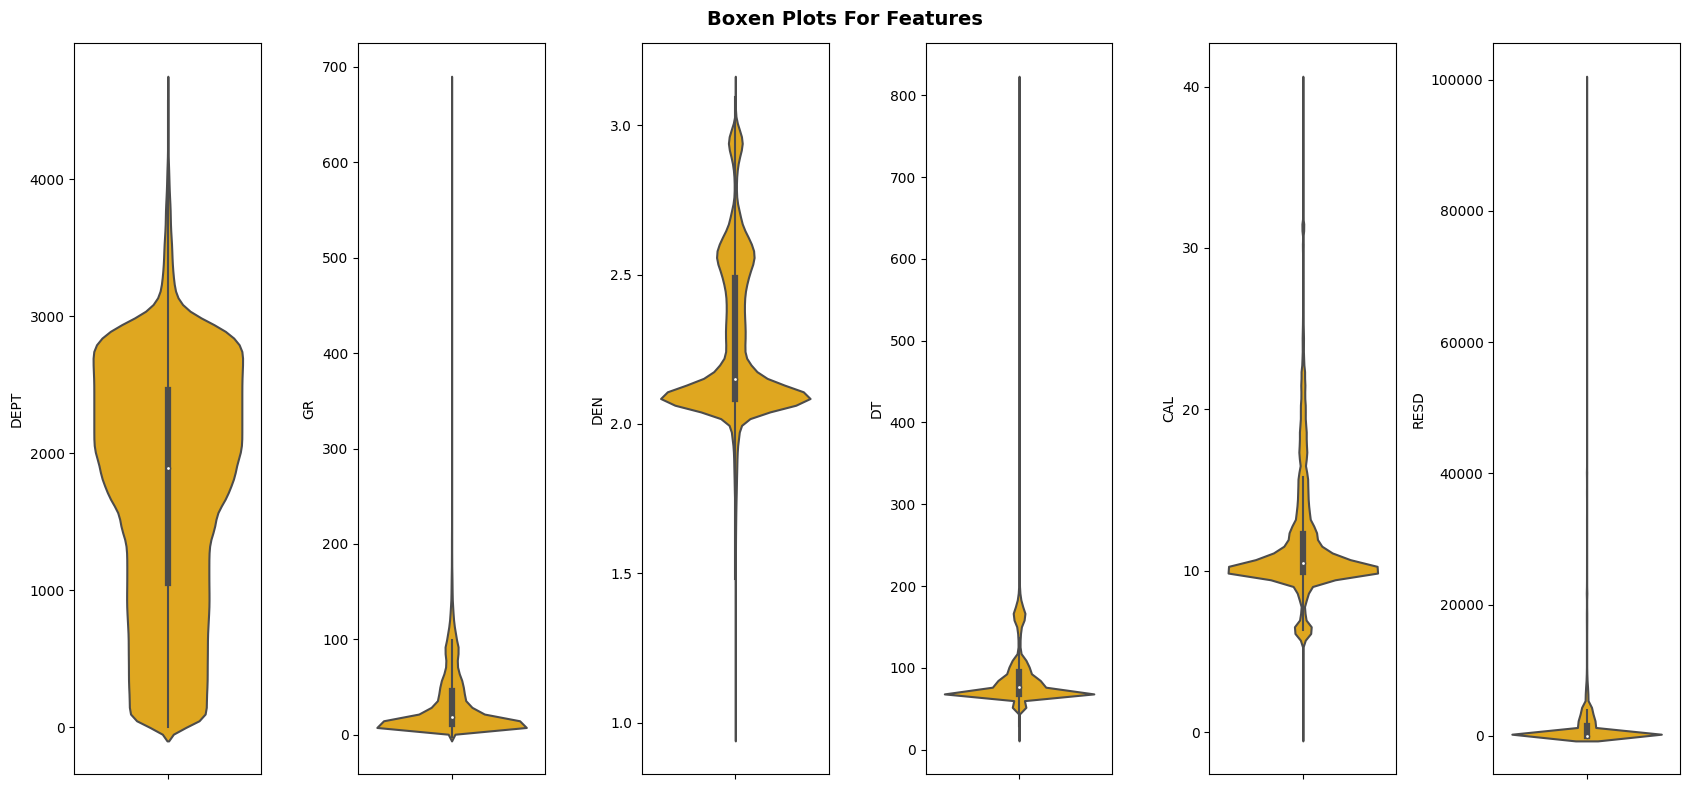

In [16]:
col = ['DEPT', 'GR', 'DEN', 'DT', 'CAL', 'RESD']
_, axes = plt.subplots(1, len(col), figsize = (17,8))

for i, ax in enumerate(axes.flatten()):
    sns.violinplot(y = df[col[i]], color = "#ffb400", ax = axes[i] )

_.suptitle('Boxen Plots For Features', fontsize = 14, fontweight = 'heavy')
plt.tight_layout()
plt.show()

В основном в наших данных приобладает информация о скважинах на глубине от 1500 до 3000 метров. По данным с датчиков видно, что есть четкие границы  где находятся большинство значений, но также видно что присутствуют значения которые во много раз превышают эти значения, можно предположить, что это выбросы или ошибки измерения.  В ходе анализа было обнаружено два аномальных значения, которые были заменены на NaN. Дальнейшее исследование предлагается провести, рассматривая информацию с датчиков относительно целевой переменной.

In [17]:
df.columns = df.columns.str.lower()

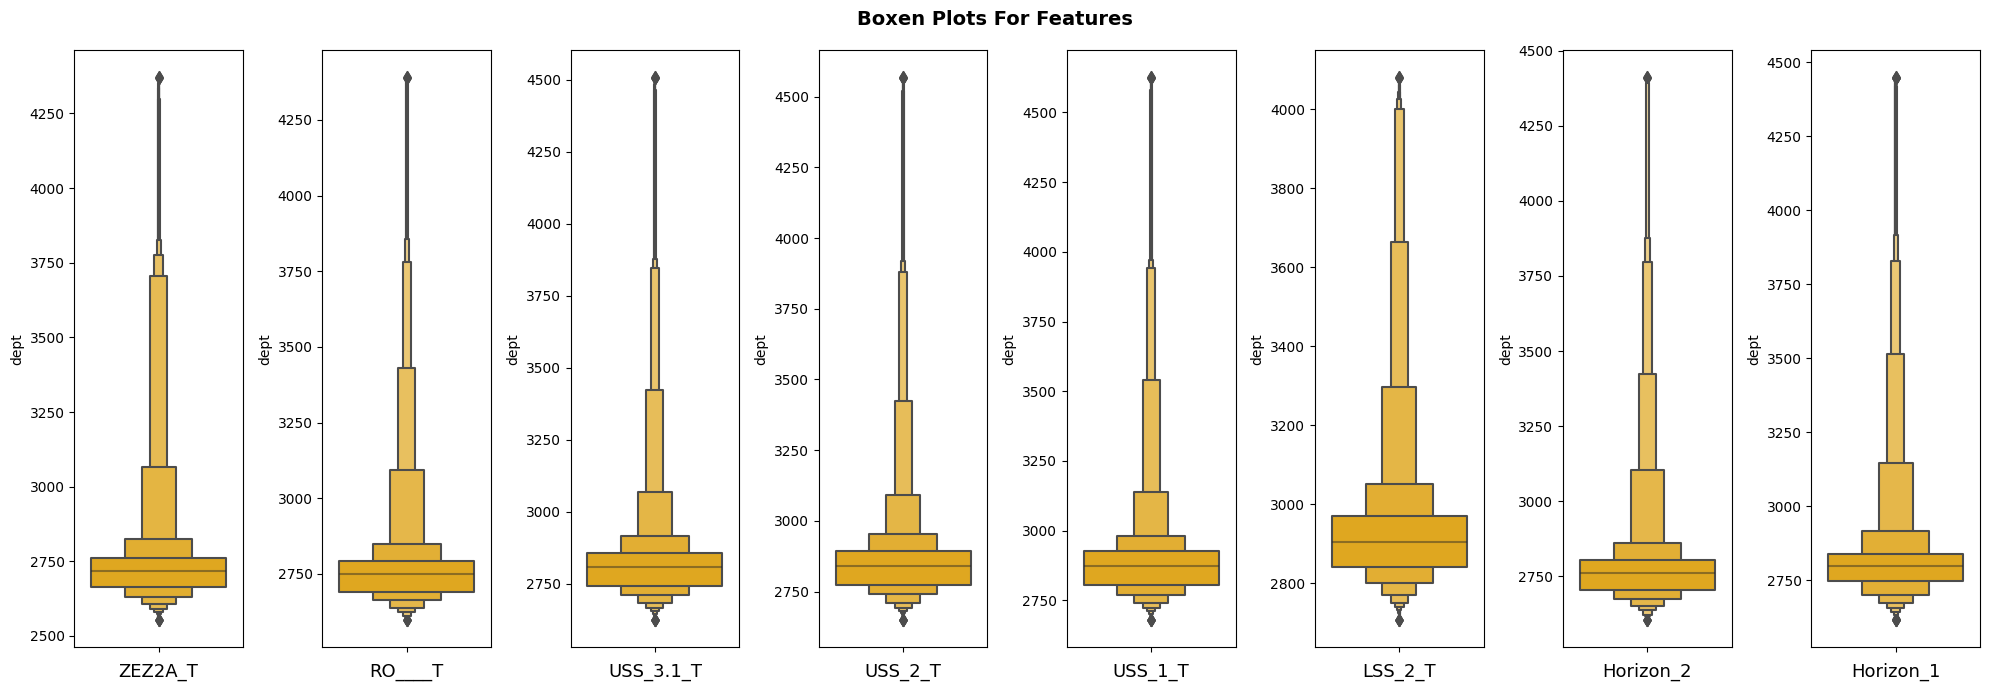

In [18]:
val = df.target.unique().tolist()[1:]
_, axes = plt.subplots(1, len(val), figsize = (20,7))
for i, ax in enumerate(axes.flatten()):
    sns.boxenplot(y = df[df.target ==val[i]].dept, color = "#ffb400", ax = axes[i] )
    axes[i].set_xlabel(val[i], fontsize=13)

_.suptitle('Boxen Plots For Features', fontsize = 14, fontweight = 'heavy')
plt.tight_layout()
plt.show()

Почти  все таргеты, имеют самое большое распределин относительно глубины в районе 2700 - 2800 метров и только слой LSS_2_T отличается от них. 

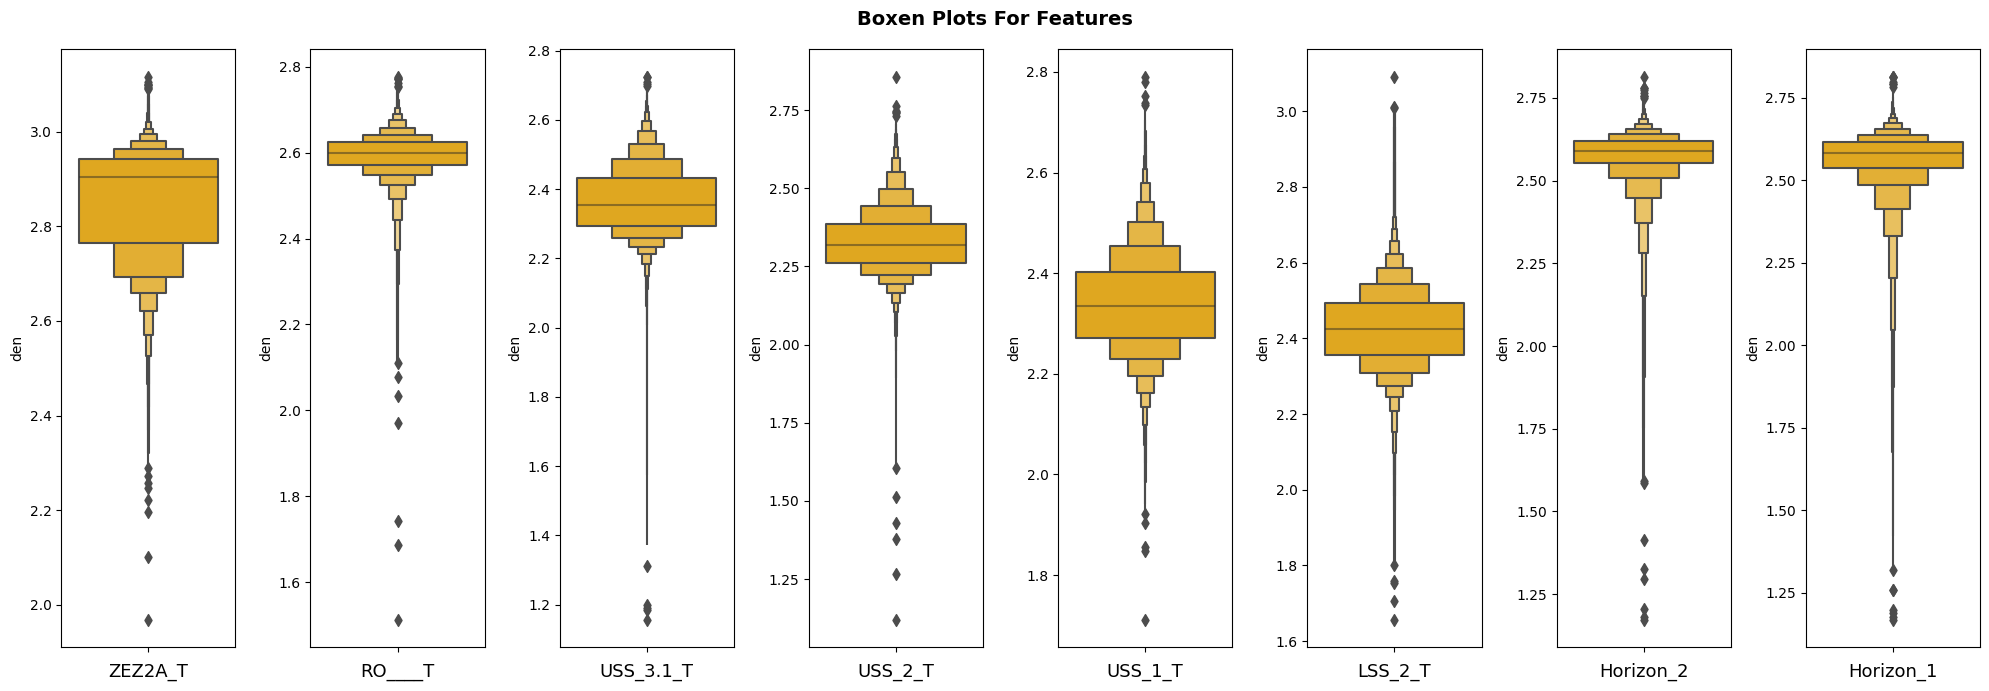

In [19]:
val = df.target.unique().tolist()[1:]
_, axes = plt.subplots(1, len(val), figsize = (20,7))
for i, ax in enumerate(axes.flatten()):
    sns.boxenplot(y = df[df.target ==val[i]].den, color = "#ffb400", ax = axes[i] )
    axes[i].set_xlabel(val[i], fontsize=13)

_.suptitle('Boxen Plots For Features', fontsize = 14, fontweight = 'heavy')
plt.tight_layout()
plt.show()

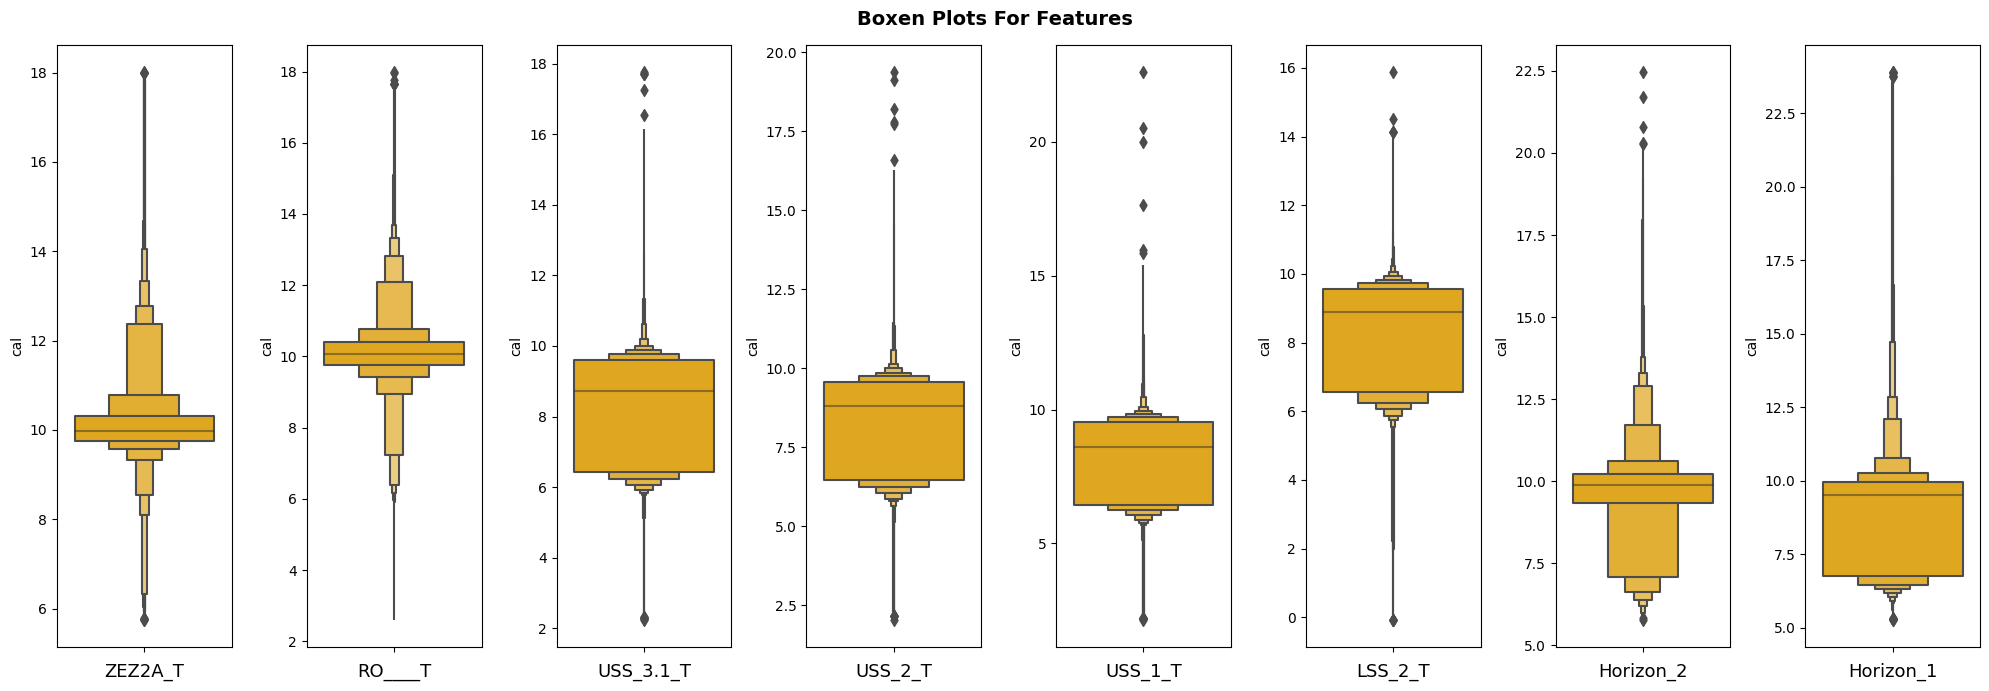

In [20]:
val = df.target.unique().tolist()[1:]
_, axes = plt.subplots(1, len(val), figsize = (20,7))
for i, ax in enumerate(axes.flatten()):
    sns.boxenplot(y = df[df.target ==val[i]].cal, color = "#ffb400", ax = axes[i] )
    axes[i].set_xlabel(val[i], fontsize=13)

_.suptitle('Boxen Plots For Features', fontsize = 14, fontweight = 'heavy')
plt.tight_layout()
plt.show()

В зависимости от слоя можно предположить необходимость введения дополнительной группировки скважин, что в будущем может быть полезно для задачи многоклассовой классификации. Требуется небольшая предварительная обработка данных, включая устранение выбросов, а также принятие решения относительно их обработки.


In [21]:
labl_enc = LabelEncoder()
df['wellname_code'] = labl_enc.fit_transform(df.wellname.values)
le = pd.get_dummies(df['target']).astype('float32')
df = pd.concat([df, le,],axis=1)


## Генерация фичей  


**3. Расширим признаковое** пространство используя методы feature engineering для временных рядов


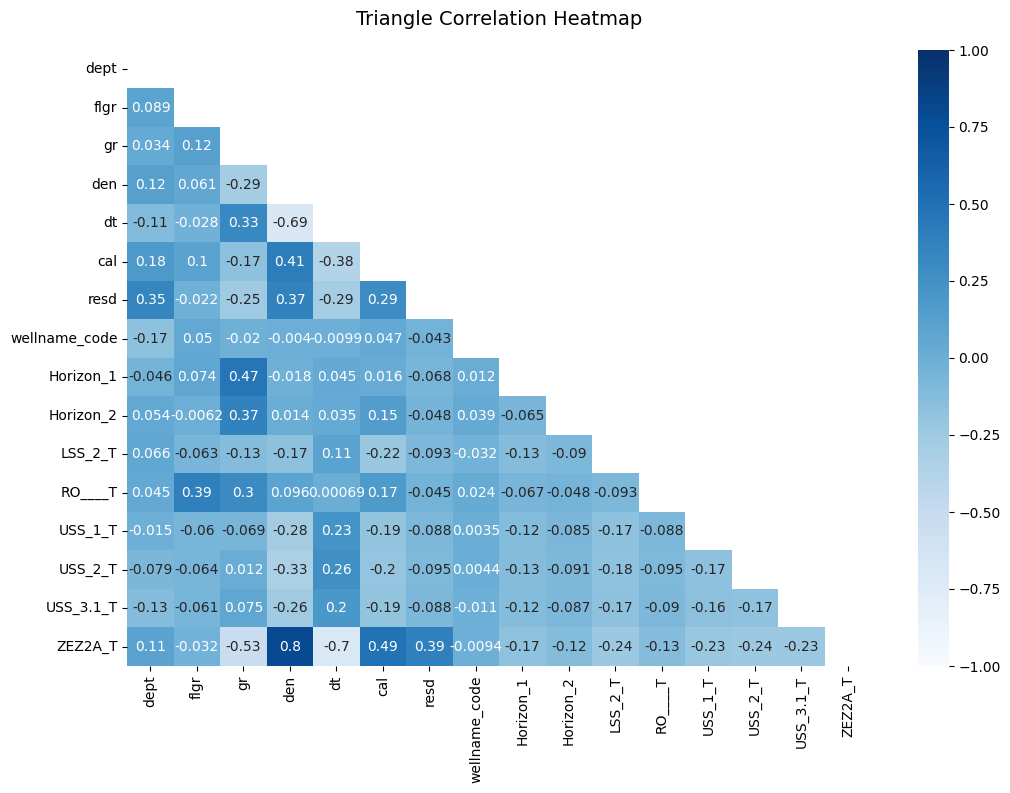

In [22]:
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df.dropna().drop(['target','wellname'],axis = 1).corr()))
heatmap = sns.heatmap(df.dropna().drop(['target','wellname'],axis = 1).corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':14}, pad=18);

In [23]:
df.isna().sum()/len(df)

dept             0.000000
target           0.903124
wellname         0.000000
flgr             0.653646
gr               0.248017
den              0.526023
dt               0.749715
cal              0.387703
resd             0.737436
wellname_code    0.000000
Horizon_1        0.000000
Horizon_2        0.000000
LSS_2_T          0.000000
RO____T          0.000000
USS_1_T          0.000000
USS_2_T          0.000000
USS_3.1_T        0.000000
ZEZ2A_T          0.000000
dtype: float64

In [24]:
df.target.value_counts()

target
ZEZ2A_T      36618
USS_2_T      24449
USS_1_T      22557
USS_3.1_T    22535
LSS_2_T      18700
Horizon_1    14338
Horizon_2     9411
RO____T       8352
Name: count, dtype: int64

В данных наблюдается значительное количество пропущенных значений с датчиков, причем в некоторых колонках пропуски составляют до 75% от общего числа значений. Вопрос очистки данных и возможных методов заполнения пропусков вызывает затруднения из-за отсутствия понимания их специфики и масштаба шкал. 


In [25]:
df_new = df[~df.index.isin(df.query('target.isna() and gr.isna() and resd.isna() and cal.isna() and dt.isna() and den.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('gr.isna() and resd.isna() and cal.isna() and dt.isna() and den.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('target.isna() and resd.isna() and cal.isna() and dt.isna() and den.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('target.isna() and dt.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('den.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('target.isna() and resd.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('target.isna() and dt.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('target.isna() and cal.isna() ').index.tolist())]
df_new = df_new[~df_new.index.isin(df_new.query('dt.isna() and resd.isna() and cal.isna()').index.tolist())]
df_new = df_new.dropna(subset = ['gr'])

df_new = df_new.drop('flgr',axis =1).reset_index(drop= True)

# df_new.head()

In [26]:
df_new.isna().sum()/len(df_new)

dept             0.000000
target           0.473118
wellname         0.000000
gr               0.000000
den              0.000000
dt               0.385425
cal              0.001529
resd             0.257301
wellname_code    0.000000
Horizon_1        0.000000
Horizon_2        0.000000
LSS_2_T          0.000000
RO____T          0.000000
USS_1_T          0.000000
USS_2_T          0.000000
USS_3.1_T        0.000000
ZEZ2A_T          0.000000
dtype: float64

Мы успешно провели очистку данных от пропусков, не сильно уменьшив количество наблюдений для целевой переменной. Однако остаются две колонки, в которых отсутствует от 25 до 38% данных. Попробуем побороться за них с помощью методов машинного обучения и на какое-то время представим, что нашей целью будут эти две колонки.

In [27]:
df_cluster = df_new.groupby(['wellname_code' ]).agg(
                                           max_dept = ('dept','max'),
                                           mean_dept = ('dept','mean'),
                                           min_den = ('den','min'),
                                           max_den = ('den','max'),
                                           mean_den = ('den','mean'),
                                           #mean_cal= ('cal','mean'),
                                           mean_gr= ('gr','mean'),
                                           
                                                    ).reset_index()
df_cluster.head(3)

,wellname_code,max_dept,mean_dept,min_den,max_den,mean_den,mean_gr
0,0,2958.5,1621.00,1.657153,2.988067,2.213420,24.556666
1,1,3060.0,2918.75,2.128264,2.992948,2.497009,56.277998
2,2,2936.0,2814.75,2.129000,2.939000,2.468514,64.875315


In [28]:
scaled_matrix = minmax_scale(df_cluster)
df_cl = pd.DataFrame(scaled_matrix,columns =df_cluster.columns )

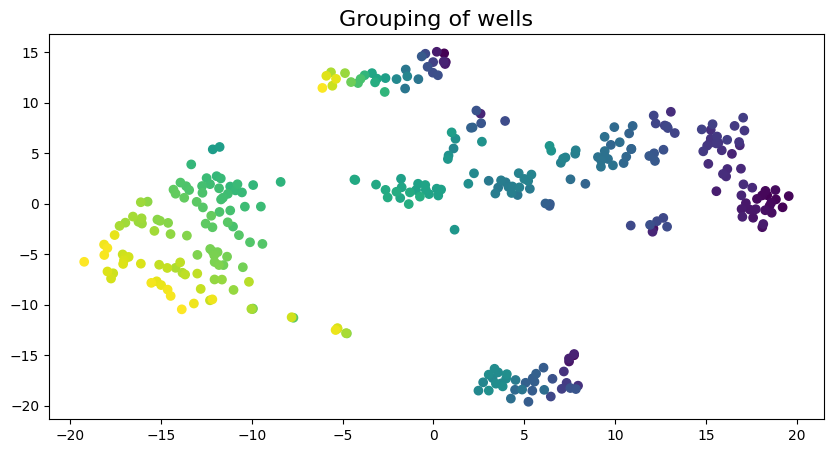

In [29]:
model = TSNE(n_components=2, learning_rate='auto',                  ) 

transformed = model.fit_transform(df_cl)

x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.figure(figsize=(10, 5))
plt.title('Grouping of wells',fontsize=16)
plt.scatter(x_axis, y_axis,c=df_cl.wellname_code ) #c=df_cluster.dropna().target 
plt.show()

In [30]:
from sklearn.cluster import KMeans

# ks = range(1, 10)
# inertias = []
 
# for k in ks:
#     model = KMeans(n_clusters=k)
#     model.fit(df_cl)
#     inertias.append(model.inertia_)
     
# plt.plot(ks, inertias, '-o')
# plt.xlabel('number of clusters, k')
# plt.ylabel('inertia')
# plt.xticks(ks)
# plt.show()

In [31]:
model_cluster = KMeans(n_clusters=6) #5
df_cluster['labels'] = model_cluster.fit_predict(df_cl)


In [32]:
df_new['group_wells'] = 0

dict_group = {}
for well, label in zip(df_cluster['wellname_code'].values, df_cluster['labels'].values):
    dict_group[well] = label

df_new['group_wells'] = df_new['wellname_code'].apply(lambda x: dict_group.get(x, 'Unknown'))


In [33]:
columns = ['dept', 'target', 'wellname', 'group_wells','gr', 'den', 'dt', 'cal', 'resd',
       'wellname_code', 'Horizon_1', 'Horizon_2', 'LSS_2_T', 'RO____T',
       'USS_1_T', 'USS_2_T', 'USS_3.1_T', 'ZEZ2A_T', ]
df_new =df_new[columns]

Итак, мы сгруппировали наши скважины в группы. По данным наших исследований, все скважины можно разделилить на 5 или 6 категорий. Мы получили одну дополнительную фичу и в дальнейшем  будем  анализировать ее влияние на датасет.

In [34]:
labl = LabelEncoder()

df_new['type_wellname'] = labl.fit_transform(df_new.wellname.apply(lambda x:x.split('-')[0]))
df_new = df_new[['dept', 'target', 'wellname','type_wellname', 'group_wells', 'gr', 'den', 'dt', 'cal',
       'resd', 'wellname_code', 'Horizon_1', 'Horizon_2', 'LSS_2_T', 'RO____T',
       'USS_1_T', 'USS_2_T', 'USS_3.1_T', 'ZEZ2A_T']]


Предположим, что скважины с аналогичными названиями вероятно имеют схожий тип, строение или другие характеристики. В будущем эта новая фича может оказаться полезной.



 
 Для очистки данных от выбросов предлагается анализировать каждую скважину отдельно. Учитывая, что в датасете содержится информация из различных районов с разнообразными типами почв и пород, а следовательно, и различной информацией с датчиков, этот подход кажется разумным.

In [35]:
names = df.wellname.unique()

In [36]:
def clean_df(df, col_name):
    names = df['wellname'].unique()#.values
    
    clean_data = []
    
    for name in names:
        temp = df[df['wellname'] == name][col_name]
        
        q1, q3 = np.percentile(temp, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        
        clean_data.append(df[df.index.isin(temp[(temp <= upper_bound) & (temp >= lower_bound)].index)])
    
    clean_df = pd.concat(clean_data, ignore_index=True)
    
    return clean_df

# df_clean = clean_df(df_new,'den')
# df_clean = clean_df(df_clean,'gr')


In [37]:

# with open('df.pickle', 'wb') as f:
#     pickle.dump(df_clean, f)

In [38]:
with open('/kaggle/input/df-clean-11/df (1).pickle', 'rb') as f:
    df_clean = pickle.load(f)

    
print('Количество выбросов = ',len(df_new)-len(df_clean))   

Количество выбросов =  14165


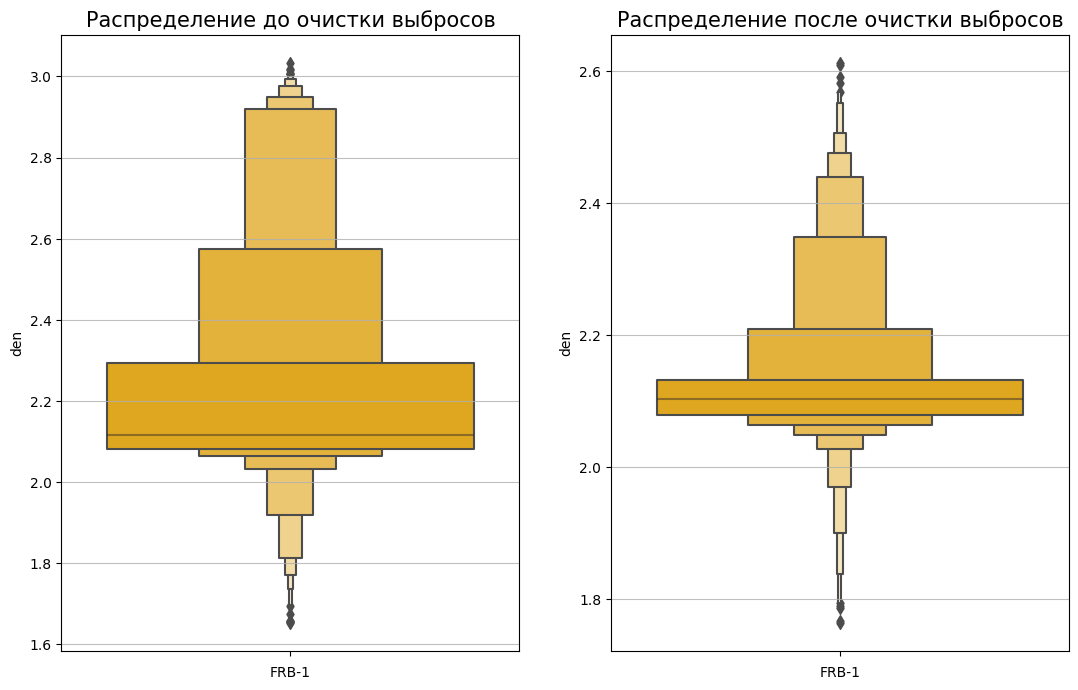

In [39]:
plt.figure(figsize=(13,8))

plt.subplot(1, 2, 1)
plt.grid(alpha=0.8)

sns.boxenplot(y = df_new[df_new.wellname==names[69]]['den'],color = "#ffb400", ) ;
plt.xlabel(names[69])
plt.title("Распределение до очистки выбросов", fontsize=15)


plt.subplot(1, 2, 2)
plt.grid(alpha=0.8)

sns.boxenplot(y = df_clean[df_clean.wellname==names[69]]['den'], color = "#ffb400", ) ;

plt.xlabel(names[69])
plt.title("Распределение после очистки выбросов", fontsize=15)
plt.show()



После тщательной работы с пропущенными значениями я разработал две стратегии:

1. Разбить данные на два датасета, в каждом из которых будет разное количество колонок. В первом датасете будут скважины, где колонки "dt" и "resd" полностью состоят из NaN. Для этих скважин мы удалим эти колонки и затем создадим модель для определения целевых переменных. Во втором наборе будут включены все колонки. Для колонок "dt" и "resd" в этом датасете мы попробуем обучить модель, которая заменит нам эти пропуски.

2. Попробовать обучить модель, которая будет предсказывать значения пропущенных данных "dt" и "resd" на основе остальных доступных признаков. 


In [40]:
labl = LabelEncoder()
df_clean['target'] = labl.fit_transform(df_clean.target.values)

In [41]:
all_na = pd.DataFrame(df_clean.query('dt.isna()').wellname.value_counts().reset_index())
all_na['total_count'] = all_na['wellname'].apply(lambda x : len(df_clean[df_clean.wellname==x]))
all_na ['norm_count'] = all_na['count']/all_na['total_count']

wellname_na = all_na[all_na.norm_count>=0.61].wellname.tolist()
wellname_na.extend(['ZND-11','PAU-6', 'SAP-10', 'EKR-208', 'AMR-12A'])
wellname_na.extend(['SAP-8', 'BIR-2A', 'ZVN-2', 'ZND-12B', 'KPD-4', 'TJM-2B', 'EKL-12', 'KPD-12'])
df_na = df_clean[df_clean.wellname.isin(wellname_na)]

df_clean = df_clean[~df_clean.wellname.isin(wellname_na)]

# df_clean.drop(['target','wellname'],axis = 1,inplace = True)
# df_na.drop(['target','wellname','resd','dt'],axis = 1,inplace = True)


# df_clean.drop(['wellname'],axis = 1,inplace = True)
df_na.drop(['resd','dt'],axis = 1,inplace = True) #'wellname',

In [42]:
df_knn_inp = df_clean[df_clean.wellname.isin(['BIR-13B','TUS-4','BIR-6'])]
df_clean = df_clean[~df_clean.wellname.isin(['BIR-13B','TUS-4','BIR-6'])]

imputer = KNNImputer()

df_knn_inp.drop('wellname',inplace = True, axis =1)
knn_inp = pd.DataFrame(imputer.fit_transform(df_knn_inp))
knn_inp.columns = df_knn_inp.columns

In [43]:
df_na.isna().sum()

dept             0
target           0
wellname         0
type_wellname    0
group_wells      0
gr               0
den              0
cal              0
wellname_code    0
Horizon_1        0
Horizon_2        0
LSS_2_T          0
RO____T          0
USS_1_T          0
USS_2_T          0
USS_3.1_T        0
ZEZ2A_T          0
dtype: int64

Попробуем заполнить пропуски в колонках

In [44]:
col = ['dept', 'gr', 'den', 'dt','group_wells','wellname_code','type_wellname' ]#'resd'
train = df_clean.dropna()
target = train['cal']

X_train, X_test, y_train, y_test = train_test_split(train[col], target, test_size=0.33, random_state=12,shuffle= True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=12,shuffle= True)


In [45]:
rfc =  RandomForestRegressor()
rfc.fit(X_train, y_train)

print('rmse_test = ',MSE(y_test,rfc.predict(X_test),squared = False))
print('mse_test = ',MSE(y_test,rfc.predict(X_test),squared = True))

print('')

print('rmse_val = ',MSE(y_val,rfc.predict(X_val),squared = False))
print('mse_val = ',MSE(y_val,rfc.predict(X_val),squared = True))

rmse_test =  0.37344395000580366
mse_test =  0.1394603837959372

rmse_val =  0.40320946607868147
mse_val =  0.16257787353545539


In [46]:
pred = df_clean[df_clean.cal.isna()]
pred['cal'] = rfc.predict(pred[col])
df_clean = pd.concat([df_clean,pred]).dropna(subset='cal').sort_index()#.isna().sum()

In [47]:
imputer = KNNImputer()

temp = pd.DataFrame(imputer.fit_transform(df_clean[df_clean.columns[5:10]]))
temp.columns = df_clean.columns[5:10]
df_clean['dt'] = temp['dt'].values
df_clean['resd'] = temp['resd'].values


In [48]:
df_clean.isna().sum()

dept             0
target           0
wellname         0
type_wellname    0
group_wells      0
gr               0
den              0
dt               0
cal              0
resd             0
wellname_code    0
Horizon_1        0
Horizon_2        0
LSS_2_T          0
RO____T          0
USS_1_T          0
USS_2_T          0
USS_3.1_T        0
ZEZ2A_T          0
dtype: int64

Хочу поделиться некоторыми наблюдениями о проделанной работе. Несмотря на то, что визуально проделанная работа может не выглядеть как значительный прогресс, было затрачено много усилий на очистку данных и попытки заполнить пропуски. Были предприняты различные подходы, включая использование TabNetRegressor для заполнения пропусков в данных, а также применение блендинга простых моделей и автоматизированного машинного обучения от автоглиона. Однако лучший результат, который мне удалось достичь, был RMSE около 2. В то время как это значение кажется приемлемым, учитывая шкалу значений от 0 до 430 для переменной "dt",но не понимая специфики измерений, какая точность у измеритольного зонда и как могут повлиять наши полученные значения  на конечную оценку таргета.  Поэтому я решил разделить данные на два набора и продолжить работу с каждым из них, используя свою модель.  При желании и достаточном погружении в данные можно дальше развивать эти стратегии и пытаться предсказывать пропущенные значения. В настоящее время у нас есть три датасета без пропусков, и мы, наконец, можем перейти к разработке новых признаков.

In [49]:
df_clean.insert(loc= 6 , column='gr_cal_multi', value=df_clean['gr'] * df_clean['cal'])
df_clean.insert(loc= 7 , column='gr_change', value=df_clean['gr'].diff())
df_clean.insert(loc= 8 , column='gr_gradient', value=np.gradient(df_clean['gr']))

df_clean.insert(loc= 10 , column='den_cal_multi', value=df_clean['den'] * df_clean['cal'])
df_clean.insert(loc= 11 , column='den_change', value=df_clean['den'].diff())
df_clean.insert(loc= 12 , column='den_gradient', value=np.gradient(df_clean['den']))

df_clean.insert(loc= 14 , column='dt_cal_multi', value=df_clean['dt'] * df_clean['cal'])
df_clean.insert(loc= 15 , column='dt_change', value=df_clean['dt'].diff())
df_clean.insert(loc= 16 , column='dt_gradient', value=np.gradient(df_clean['dt']))

df_clean.insert(loc= 19 , column='log_resd', value=np.log1p(df_clean['resd']))


In [50]:
df_clean.insert(loc= 20 , column='log_resd_cal_multi', value=df_clean['log_resd'] * df_clean['cal'])
df_clean.insert(loc= 21 , column='log_resd_change', value=df_clean['log_resd'].diff())
df_clean.insert(loc= 22 , column='log_resd_gradient', value=np.gradient(df_clean['log_resd']))

cond = df_clean.target.fillna('0').map(lambda x: 1 if x!=8 else 0).astype('int')
df_clean.insert(loc= 2 , column='target_bin', value=cond)

df_clean = df_clean.drop('wellname', axis =1)


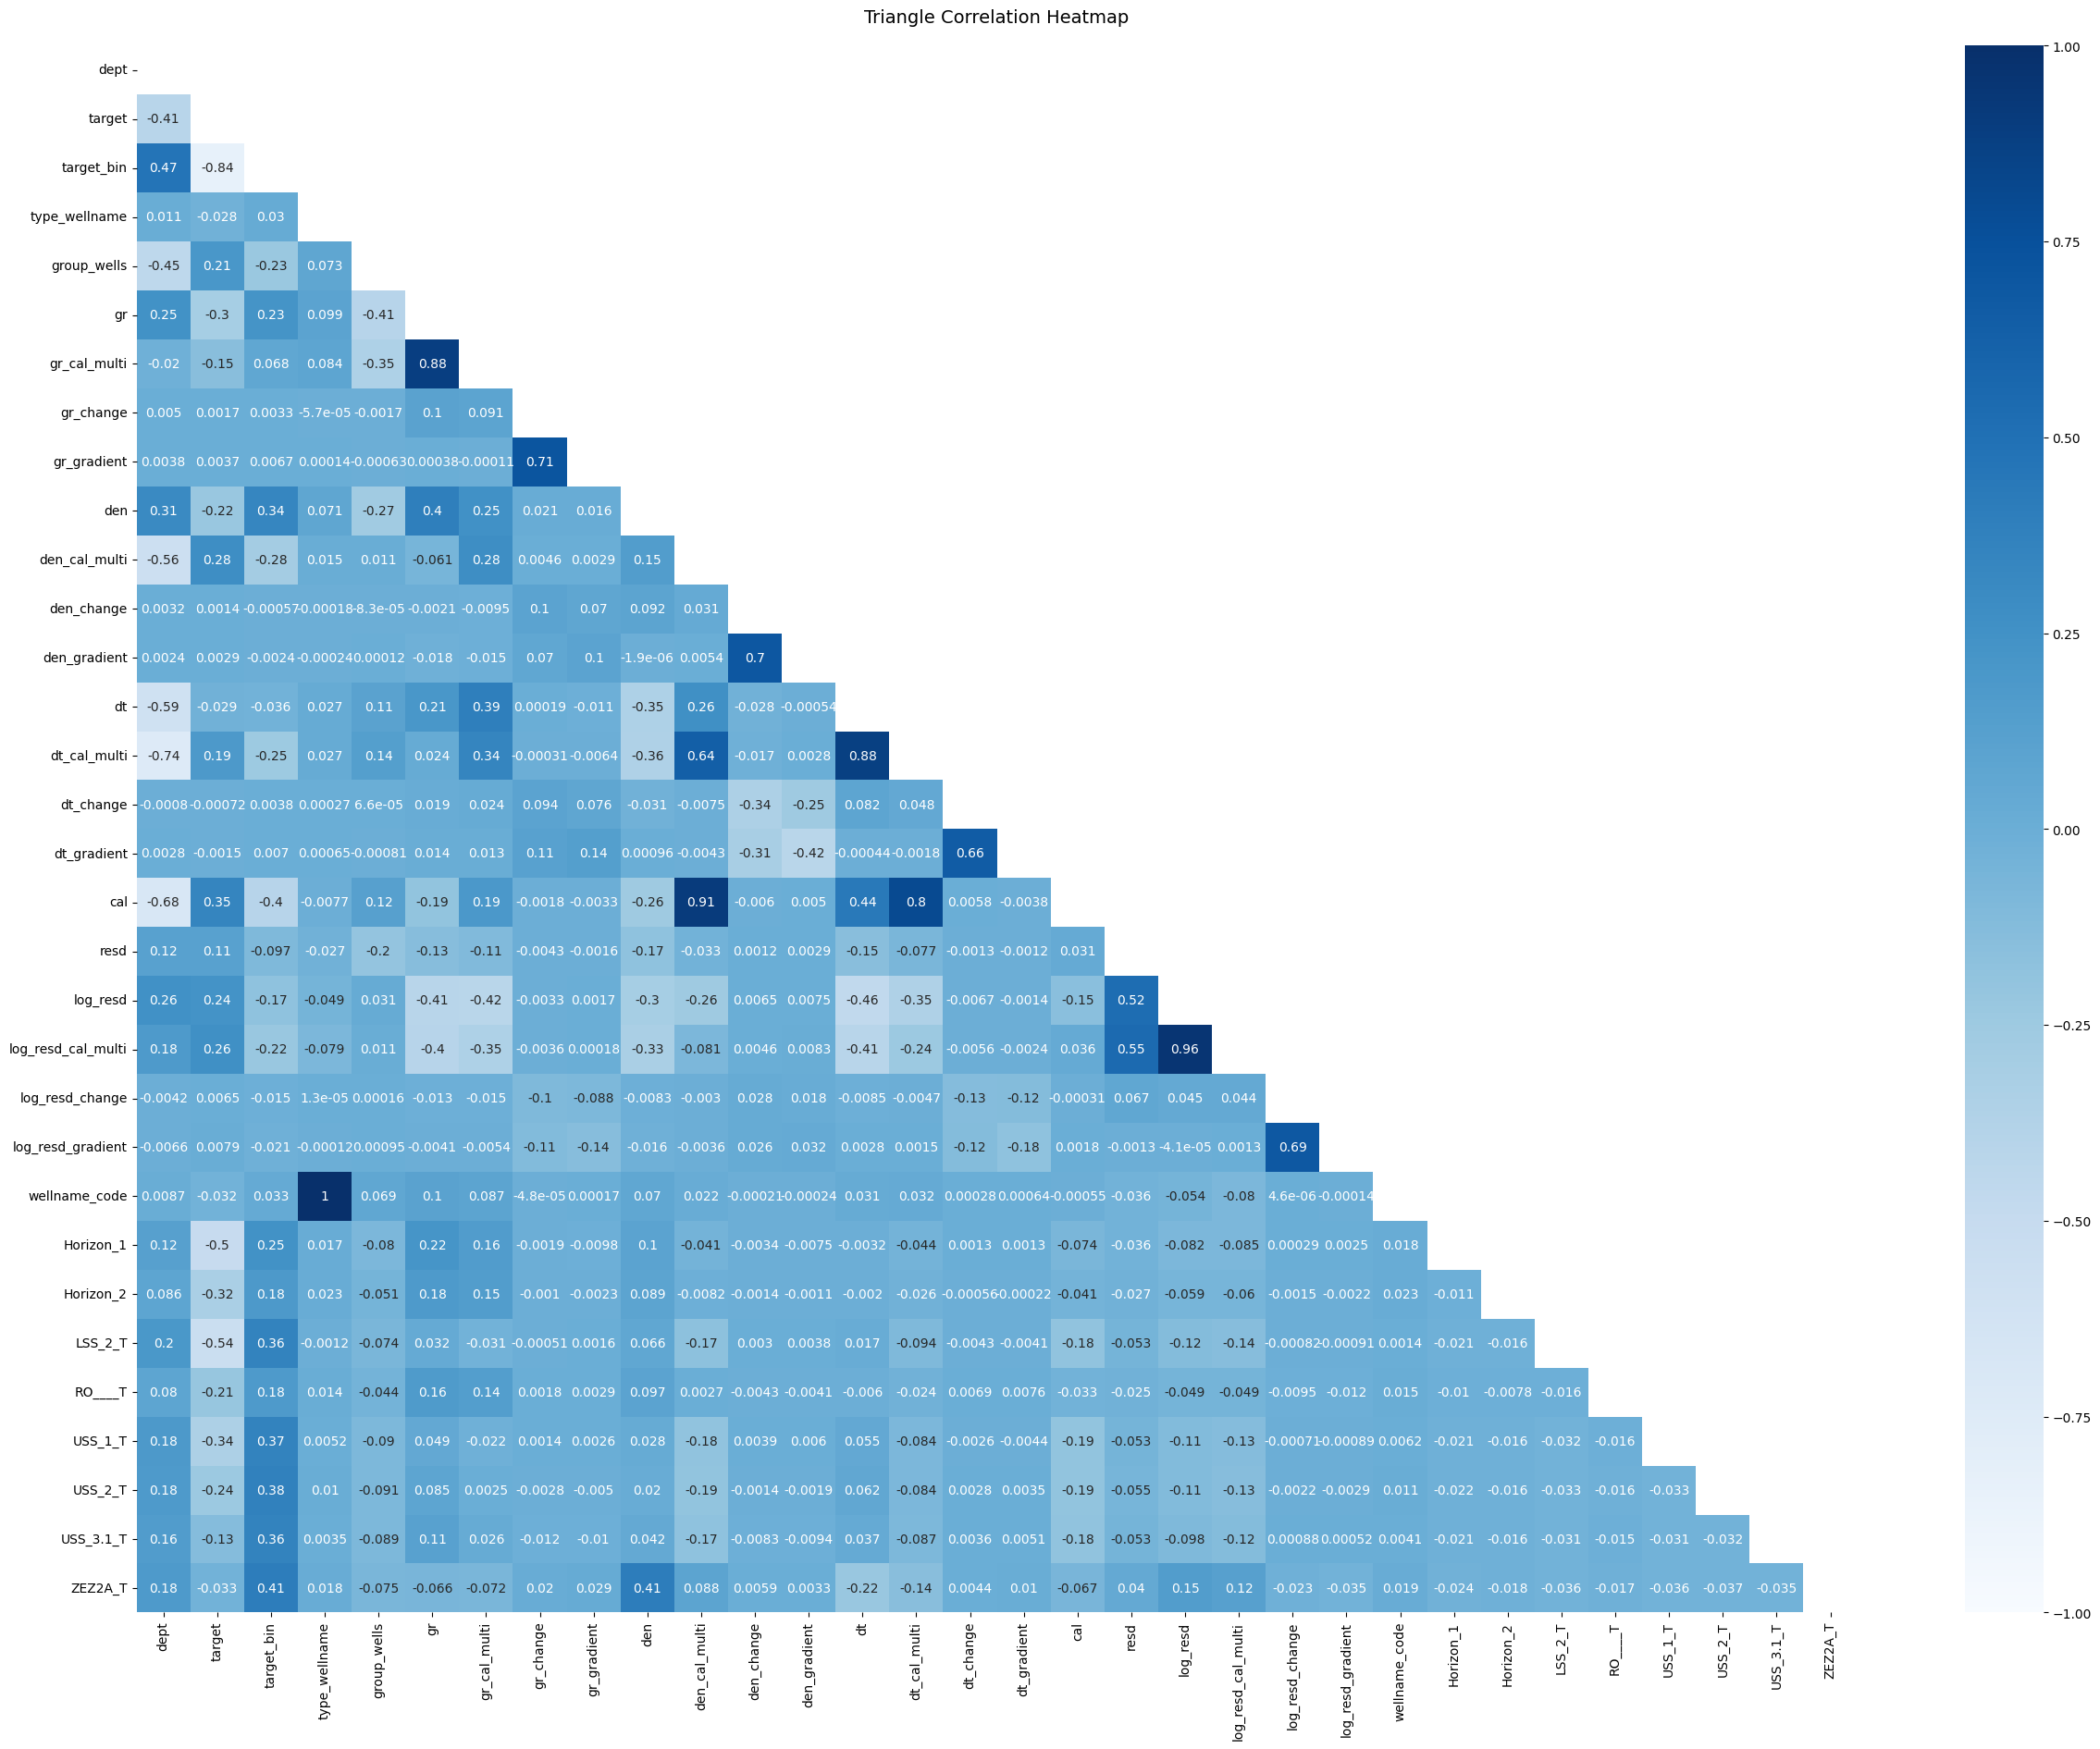

In [51]:
plt.figure(figsize=(30, 22))
mask = np.triu(np.ones_like(df_clean.corr() ))
heatmap = sns.heatmap(df_clean.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':14}, pad=18);


Мы провели анализ корреляции между нашими колонками и заметили, что целевые переменные хорошо коррелируют с данными с датчиков и с колонкой группировки вышек. Предлагается разделить колонки на два датасета: один для целевых переменных и один для признаков, которые будут использованы для прогнозирования. У нас есть три типа целевых переменных, предлагается начать с бинарной классификации, чтобы определить, на какой глубине находится любой полезный для нас слой. Затем мы можем рассмотреть возможность разделения участков шахты на различные слои. В дальнейшем, стоит попробовать многоклассовую классификацию сразу для всех слоев.


### **Моделирование**

In [52]:
target_column = [ 'target', 'target_bin', 'Horizon_1',
       'Horizon_2', 'LSS_2_T', 'RO____T', 'USS_1_T', 'USS_2_T', 'USS_3.1_T',
       'ZEZ2A_T']
df_clean =df_clean.dropna()

# val = random.sample(df_clean.wellname_code.unique().tolist(), 3, ) 

val = pd.Series(df_clean['wellname_code'].unique()).sample(7, random_state=1).tolist()

valid_wells = df_clean[df_clean.wellname_code.isin(val)].reset_index(drop= True)
train = df_clean[~df_clean.wellname_code.isin(val)].reset_index(drop= True)

target = train[target_column]
train = train[train.columns[~train.columns.isin(target.columns)]]

In [53]:
gr = train['type_wellname']

df = train
df['target_bin'] = target['target_bin']

df = df.reset_index(drop=True)


df_val = valid_wells.drop([ 'target',  'Horizon_1',
       'Horizon_2', 'LSS_2_T', 'RO____T', 'USS_1_T', 'USS_2_T', 'USS_3.1_T',
       'ZEZ2A_T'],axis =1 )

Приминив библиотеку borutashap я получил набор функций, которые важны в наших расчетах. Я не буду проводить эти вычисления , а просто проведу закоммертированный код  и результат его выполнения. На графике будет список важности наших фичей и ниже сам список. Проэксперементировав с бинарным таргетом и датасетом я получил почти идеальный Roc AUC, что говорит об утечки наших значений. Мы это видим из графика кореляции, получил такой большой 'скор', я пошел изучать эту проблему. Итак библиотека от компании H2O согласилась с моими выводами и выдала мне следующие рекомендации:
 - Data leakage detected
 - Possible leakage detected in training data for feature dept (AUC: 0.9263241 )
 - Possible leakage detected in training data for feature cal (AUC: 0.8896257 )
 - Possible leakage detected in training data for feature den (AUC: 0.8793946 )
 - Possible leakage detected in training data for feature dt (AUC: 0.8757774 )
 - Consider dropping leaky features.

И возникает вопрос : А как нам быть? если это все наши данные, которые нам были даны в исходном фрейме. Можно разбить колонку с глубиной на категариальную фичу с различными точками отсчета(меньше 1000м , от 1000 до 1500м и тд), возможно, это уменьшить утечку , но не победит ее и не сильно повлияет на результат, так как я пробовал полностью удалить часть колонок из рекомендательного списка и  мой скор не сильно упал. Поэтому я предлагаю оставить все так как я задумывал с начала , что мы с хорошей вероятностью можем определить важен этот слой для нас или нет. Это будет наша дополнительная фича, возможно дальше она нам поможет в многоклассовой классификации. Так же я выделял от 2 до 6 скважин, чтобы тестировать конечные модели на этих данных(которые она не видела) и я пробовал два типа разделения на тестовый и тренировочный набор(StratifiedKFold и GroupKFold). Первый зарекомендовал себя лучше, поэтому я оставил его в своих расчетах. Можно было, конечно, поиграться с настраиваемым порогом и улучшить наши бинарную классификацию, я пробовал в GroupKFold это и улучшил конечные результаты, но  на это все нужно было затратить больше времени и я прервал эксперименты в этой области. И как писал выше остался  с StratifiedKFold. 

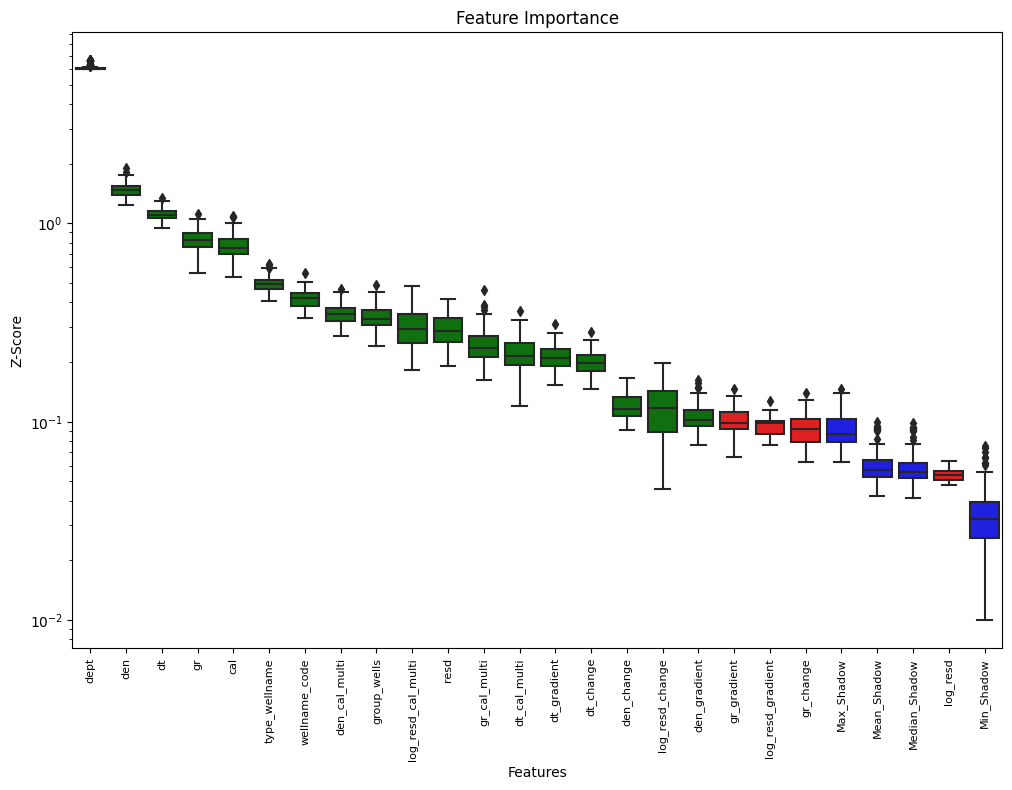

In [54]:
from PIL import Image, ImageDraw
col = ['group_wells', 'dt', 'dt_cal_multi', 'resd', 'dt_change', 'den_gradient', 'gr', 
       'type_wellname', 'den_change', 'dept', 'wellname_code', 'log_resd_change', 'gr_cal_multi', 
       'log_resd_cal_multi', 'den', 'cal', 'dt_gradient', 'den_cal_multi']

Image.open('/kaggle/input/pictures/__results___82_2.png') 


In [55]:
# !pip install borutashap
# from BorutaShap import BorutaShap
# from xgboost import XGBClassifier

# model = XGBClassifier()

# Feature_Selector = BorutaShap(model=model,
#                               importance_measure='shap',
#                               classification=True)
# target_col = 'target_bin'
# X = df.drop(['fold',target_col],axis =1)
# y = df[target_col]
 
# Feature_Selector.fit(X=X, y=y, n_trials=100, sample=False, train_or_test = 'test', normalize=True,verbose=True)
# subset = Feature_Selector.Subset()
# Feature_Selector.plot(which_features='all')


18 attributes confirmed important: **['group_wells', 'dt', 'dt_cal_multi', 'resd', 'dt_change', 'den_gradient', 'gr', 'type_wellname', 'den_change', 'dept', 'wellname_code', 'log_resd_change', 'gr_cal_multi', 'log_resd_cal_multi', 'den', 'cal', 'dt_gradient', 'den_cal_multi']**

4 attributes confirmed unimportant: **['log_resd', 'gr_change', 'gr_gradient', 'log_resd_gradient']**

0 tentative attributes remains: []

In [56]:
num_folds = 3
verbose = 500
seed = 4242
n_est = 1500 

# drop_col = ['target_bin','dept', 'log_resd', 'gr_change', 'gr_gradient', 'log_resd_gradient','cal' ,'den', 'dt']

drop_col = ['target_bin','log_resd', 'gr_change', 'gr_gradient', 'log_resd_gradient',]#'dept',]

X = df.drop(drop_col,axis =1 )

y = df['target_bin']



In [57]:
# import optuna
# from optuna.samplers import TPESampler
# X = df.drop(['target_bin',],axis =1)
# y = df['target_bin']


# def objective(trial):
        
#     folds = StratifiedKFold(
#         n_splits     = 5,
#         random_state = 42,
#         shuffle      = True
#     )

#     param = {
#         "iterations"         : 1000,
#         "used_ram_limit"     : "25gb",
#         "eval_metric"        : 'AUC',
#         "objective"          : 'Logloss',

#         "depth"              : trial.suggest_int("depth", 1, 15),
#         "min_data_in_leaf"   : trial.suggest_int("min_data_in_leaf", 1, 100),
#         "colsample_bylevel"  : trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         "learning_rate"      : trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),        
#         "l2_leaf_reg"        : trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         "random_strength"    : trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
#         "od_wait"            : trial.suggest_int("od_wait", 10, 50),

#     }


    
#     auc_vals = []
#     for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
#         X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#         X_val, y_val     = X.iloc[valid_idx], y.iloc[valid_idx]
        

#         train_pool = Pool(X_train, 
#                           y_train, 
#                           )

#         val_pool   = Pool(X_val, 
#                           y_val,
#                           )
    
#         clf = CatBoostClassifier(**param)
#         clf.fit(train_pool, 
#                 eval_set              = val_pool,
#                 verbose               = 50,
#                 early_stopping_rounds = 100
#         )

    
#         y_pred_val = clf.predict_proba(X_val)[:,1]
#         auc_val    = roc_auc_score(y_val, y_pred_val)
#         auc_vals.append(auc_val)
#         print(f"Confusion matrix :\n {confusion_matrix( clf.predict(X_val),y_val)}")

#     return np.mean(auc_vals)




# if __name__ == "__main__":


#     study = optuna.create_study(direction="maximize")
#     study.optimize(objective, n_trials=20)

#     print("Number of finished trials: {}".format(len(study.trials)))
#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))
#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [58]:
bestParams = {'depth': 8, 'min_data_in_leaf': 95, 
              'colsample_bylevel': 0.9906744781259593,
              'learning_rate': 0.015374987410408108,
              'l2_leaf_reg': 0.21454386836792207,
              'random_strength': 0.00037529112479686667, 
              'od_wait': 25}

bestParams = {
    **{'eval_metric' : 'AUC', 'iterations' : n_est},
    **bestParams
}

In [59]:
# folds = StratifiedGroupKFold(n_splits=num_folds)
    
# auc_vals = []
# f1_vals = []
# for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y,groups=gr)):
    
#     X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#     X_val, y_val     = X.iloc[valid_idx], y.iloc[valid_idx]
    
#     train_pool = Pool(X_train, y_train, )
    
#     val_pool   = Pool(X_val, y_val,)
    
#     clf = CatBoostClassifier(**bestParams)
    
#     clf.fit(train_pool, eval_set = val_pool, verbose  = 500)
    
#     y_pred_val = clf.predict_proba(X_val)[:,1]
    
#     auc_val    = roc_auc_score(y_val, y_pred_val)
    
#     f1_val = f1_score(y_val, clf.predict(X_val), average='macro')

#     print("AUC for fold ",n_fold,": ",auc_val)
#     print(f"f1 score  {f1_val}")

#     auc_vals.append(auc_val)
#     f1_vals.append(f1_val)

#     print(f"Confusion matrix :\n {confusion_matrix(y_val, clf.predict(X_val),)}")
#     print(f"Confusion matrix :\n {confusion_matrix(y_val,clf.predict_proba(X_val)[:,1] >= 0.47)}")

#     print("----------------")


In [60]:
folds = StratifiedKFold(
    n_splits     = num_folds,
    random_state = seed,
    shuffle      = True)

auc_vals = []
f1_vals = []
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val     = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train, )
    
    val_pool   = Pool(X_val, y_val,)
    
    clf = CatBoostClassifier(**bestParams)
    
    clf.fit(train_pool, eval_set = val_pool, verbose  = 500)
    
    y_pred_val = clf.predict_proba(X_val)[:,1]
    auc_val    = roc_auc_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, clf.predict(X_val), average='macro')
    
    
    print("AUC for fold ",n_fold,": ",auc_val)
    print(f"f1 score  {f1_val}")

    auc_vals.append(auc_val)
    f1_vals.append(f1_val)

    print(f"Confusion matrix :\n {confusion_matrix(y_val, clf.predict(X_val),)}")
    print("----------------")

    print(f"Confusion matrix with threshold :\n {confusion_matrix(y_val,clf.predict_proba(X_val)[:,1] >= 0.47)}")

    print("----------------")


0:	test: 0.9897016	best: 0.9897016 (0)	total: 81.2ms	remaining: 2m 1s
500:	test: 0.9997945	best: 0.9997945 (500)	total: 12.6s	remaining: 25.2s
1000:	test: 0.9998902	best: 0.9998904 (993)	total: 24.6s	remaining: 12.2s
1499:	test: 0.9999145	best: 0.9999145 (1499)	total: 36.6s	remaining: 0us

bestTest = 0.9999145174
bestIteration = 1499

AUC for fold  0 :  0.9999145174085861
f1 score  0.9948085569648791
Confusion matrix :
 [[35119    94]
 [   42  7979]]
----------------
Confusion matrix with threshold :
 [[35112   101]
 [   39  7982]]
----------------
0:	test: 0.9882599	best: 0.9882599 (0)	total: 27ms	remaining: 40.5s
500:	test: 0.9998595	best: 0.9998595 (499)	total: 12.6s	remaining: 25.1s
1000:	test: 0.9999303	best: 0.9999303 (1000)	total: 24.5s	remaining: 12.2s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.9999419159
bestIteration = 1263

Shrink model to first 1264 iterations.
AUC for fold  1 :  0.9999419159319985
f1 score  0.995530594654102
Confusion matrix :
 [[3

In [61]:
print("Mean AUC: ",np.mean(auc_vals))
print("Mean F1: ",np.mean(f1_vals))

Mean AUC:  0.9999175524721968
Mean F1:  0.9950087617630509


In [62]:
def conf_matrix(X,y, normalize= None,title = None):
    class_names = ['0','1']
    disp = ConfusionMatrixDisplay.from_estimator(
            clf,
            X,
            y,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize)
    plt.title(title, fontsize=10)

    
    plt.show()

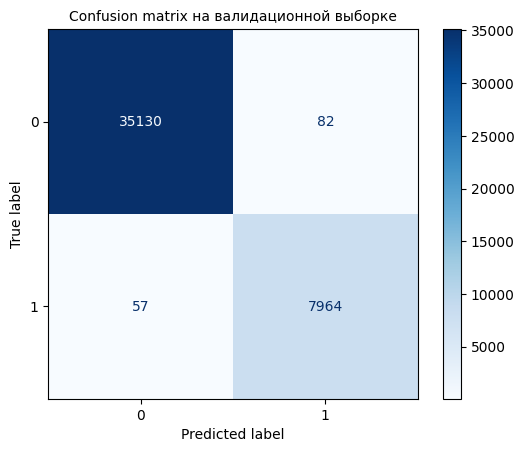

In [63]:
conf_matrix(X_val,y_val, None,'Confusion matrix на валидационной выборке')


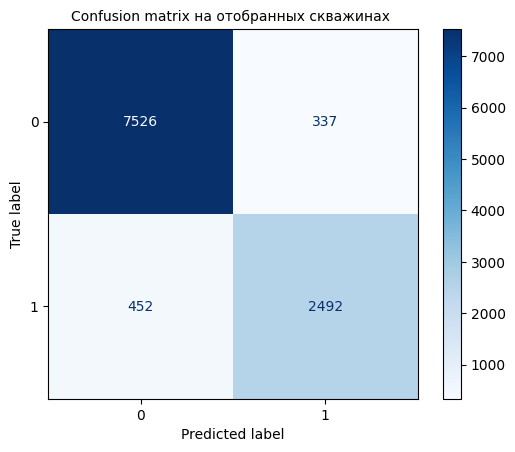

In [64]:
conf_matrix(df_val.drop(drop_col,axis =1 ),
        df_val['target_bin'], None,'Confusion matrix на отобранных скважинах ')


Видно, что мы получили очень хороший результат, даже на пяти отобранных скважинах, которая наша модель не видела, в процессе обучения.Это говорит о том, что мы по данным с наших датчиков можем с хорошей точностью предсказать на какой глубине будут слои, важные для наших исследований или добычи ископаемых.
Следующим шагом мы усложним задачу и попробуем в этом датасете многоклассовую  классификацию. 

In [65]:
df['target_bin_pred'] = clf.predict(df.drop(drop_col,axis =1 ))

In [66]:
df_val['target_bin_pred'] = clf.predict(df_val.drop(drop_col,axis =1 ))


In [67]:
df['target'] = target['target']
df_val['target'] = valid_wells['target']

In [68]:

# drop_col = ['target_bin','dept', 'log_resd', 'gr_change', 'gr_gradient', 'log_resd_gradient','cal' ,'den', 'dt']

drop_col = ['target_bin','target']#,'dept',

X = df.drop(drop_col,axis =1 )

y = df['target']

In [69]:
f1_vals = []
mult_clf = CatBoostClassifier(
                          n_estimators=2000, 
                          verbose=500,
                          bootstrap_type="Bernoulli",
                          loss_function='MultiClass',
                          )

folds = GroupKFold(n_splits=num_folds)
gr = df.type_wellname 

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y,groups=gr)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val     = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train, )
    
    val_pool   = Pool(X_val, y_val,)
    
    
    mult_clf.fit(train_pool, eval_set = val_pool)
    
    
    f1_val = f1_score(y_val, mult_clf.predict(X_val), average=None)
    
    print("f1 for fold ",n_fold,": \n",f1_val)

    f1_vals.append(f1_val)
    print("----------------")

    print(f"Confusion matrix :\n {confusion_matrix(y_val, mult_clf.predict(X_val))}")
    print("----------------")
    print(classification_report(y_val,mult_clf.predict(X_val)))
    print("----------------")




Learning rate set to 0.090584
0:	learn: 1.5980675	test: 1.6231249	best: 1.6231249 (0)	total: 127ms	remaining: 4m 13s
500:	learn: 0.0467548	test: 0.3104430	best: 0.2516466 (65)	total: 35.3s	remaining: 1m 45s
1000:	learn: 0.0255314	test: 0.3527494	best: 0.2516466 (65)	total: 1m 10s	remaining: 1m 10s
1500:	learn: 0.0165037	test: 0.3805270	best: 0.2516466 (65)	total: 1m 46s	remaining: 35.4s
1999:	learn: 0.0114934	test: 0.4030127	best: 0.2516466 (65)	total: 2m 22s	remaining: 0us

bestTest = 0.2516465853
bestIteration = 65

Shrink model to first 66 iterations.
f1 for fold  0 : 
 [0.47650131 0.22964509 0.51488616 0.46401985 0.39251701 0.29800307
 0.37398374 0.97817109 0.99926939]
----------------
Confusion matrix :
 [[  365    34    54   158     0     7    26     0     6]
 [  154    55     3   120     0     2    13     2     0]
 [   38     0  1029     9   334    26   131    25     7]
 [   73    36     3   187     0     0     3    11     0]
 [   23     0   576     3   577   119   198     7    

In [70]:
print("Mean F1 per class:\n",pd.DataFrame(f1_vals).mean(axis = 0))

Mean F1 per class:
 0    0.501893
1    0.201555
2    0.524763
3    0.436976
4    0.322457
5    0.333414
6    0.485316
7    0.966591
8    0.999293
dtype: float64


In [71]:
print(confusion_matrix(df_val.target, mult_clf.predict(df_val.drop([ 'target',  'target_bin'],axis =1))))
print("------------------------------------------------")
print(f1_score(df_val.target, mult_clf.predict(df_val.drop([ 'target',  'target_bin'],axis =1)), average=None))



[[ 160    7    1   44    2    3   34    0   49]
 [  90   11    0   17    0    0    4    0   24]
 [  12    0  277    0   17    2    5    0  154]
 [  34   15    0   63    0    0    0    1   19]
 [   8    0  105    0  149   52   12    0   98]
 [   5    0  115    0   91  167   54    0   14]
 [  23    0   88    0   41   57  180    0    8]
 [   3    2    0    2    0    0    0  539   86]
 [  87    1   57    2    6    0   10  174 7526]]
------------------------------------------------
[0.4432133  0.12087912 0.4990991  0.48461538 0.40821918 0.45942228
 0.51724138 0.80089153 0.95019254]


In [72]:
!pip install py-boost -q


In [73]:
import py_boost as pb
from py_boost import TLPredictor, TLCompiledPredictor,GradientBoosting
from py_boost.cv import CrossValidation

from py_boost import GradientBoosting

from py_boost.multioutput.sketching import *
from py_boost.multioutput.target_splitter import *


In [74]:
df_gr = df.reset_index(drop=True)
X_gr = df_gr.drop(['target_bin','target'],axis = 1)
y_gr = df_gr['target']
gr = df_gr['type_wellname']

In [75]:
# sketch = RandomProjectionSketch(1)
# sketch = RandomSamplingSketch(10)
sketch = TopOutputsSketch(9)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_gr, y_gr,groups=gr)):

    
    X_train, y_train = X_gr.values[train_idx], y_gr.values[train_idx]
    X_val, y_val     = X_gr.values[valid_idx], y_gr.values[valid_idx]
    
    
    model = GradientBoosting(
        'crossentropy',
        ntrees=3000, lr=0.003, verbose=500, es=300, lambda_l2=.6,
                         min_data_in_leaf=10, use_hess=False, 
                         max_bin=256, 
#         max_depth=6,
                         multioutput_sketch=sketch,
        
)

    model.fit(X_train, y_train, 
          eval_sets = [{'X': X_val, 'y': y_val}])
    print("n_fold = ", n_fold)

    pred = model.predict(X_val)
    print('-------------')

    d = pd.DataFrame(pred).T
    f = []
    for i in d.columns:
        f.append(d[i].argmax())
    pred = pd.DataFrame(f).values

    print(confusion_matrix(y_val,pred))

    print('-------------')
    
    print(classification_report(y_val,pred))
    
    print('-------------')
    

[18:15:57] Stdout logging level is INFO.
[18:15:57] GDBT train starts. Max iter 3000, early stopping rounds 300
[18:16:22] Iter 0; Sample 0, Crossentropy = 2.176650798859138; 
[18:16:35] Iter 500; Sample 0, Crossentropy = 0.3530750487055216; 
[18:16:49] Iter 1000; Sample 0, Crossentropy = 0.26533469760252865; 
[18:16:58] Early stopping at iter 1310, best iter 1010, best_score 0.2651923376890638
n_fold =  0
-------------
[[  309   113    32   152     1     9    28     0     6]
 [  106    89     2   135     0     3    14     0     0]
 [   49     0  1017     9   344    45   114    14     7]
 [   66    80     6   155     0     0     5     1     0]
 [   25     3   594     9   582   140   142     8     0]
 [   77     7   421     2   428   360   327     2     0]
 [  157    16   302    22   104   438   464     0     0]
 [    3     5     6    12     0     0     2  1646     5]
 [    4     0    20     1     0     1     1     5 34193]]
-------------
              precision    recall  f1-score   su

In [76]:
val_pred = model.predict(df_val.drop([ 'target',  'target_bin'],axis =1).values)
d = pd.DataFrame(val_pred).T
f = []
for i in d.columns:
    f.append(d[i].argmax())
val_pred = pd.DataFrame(f).values
print(confusion_matrix(df_val.target, val_pred))
print("------------------------------------------------")
print(f1_score(df_val.target, val_pred, average=None))



[[ 150   13    2   30    3    5   48    0   49]
 [  76   21    1   17    0    0    7    0   24]
 [  12    0  228    0   65    2    6    0  154]
 [  46   17    0   50    0    0    0    0   19]
 [   9    0  101    0  169   41    7    0   97]
 [   0    3  103    0   76  195   55    0   14]
 [  20    0   77    2   54  104  132    0    8]
 [   4    0    0    2    0    0    0  540   86]
 [  81    2   57    3   11    0   13  171 7525]]
------------------------------------------------
[0.42979943 0.20792079 0.44015444 0.42372881 0.42144638 0.49180328
 0.39699248 0.80416977 0.95018625]


**Стекинг наших решений** (на скорую руку)

In [77]:
catboost = pd.DataFrame(mult_clf.predict_proba(df_val.drop([ 'target',  'target_bin'],axis =1))).T
val_pred = model.predict(df_val.drop([ 'target',  'target_bin'],axis =1).values)
pyboost = pd.DataFrame(val_pred).T

stack = (np.sqrt(catboost**2+pyboost**2))/2
f = []
for i in stack.columns:
    f.append(stack[i].argmax())
pred = pd.DataFrame(f).values

print(confusion_matrix(df_val.target, pred))
print("------------------------------------------------")
print(f1_score(df_val.target, pred, average=None))


[[ 156   10    0   39    3    2   41    0   49]
 [  85   14    0   16    0    0    7    0   24]
 [  12    0  257    0   38    1    5    0  154]
 [  47   13    0   52    0    0    0    1   19]
 [   8    0  115    0  149   46    8    0   98]
 [   4    0  116    0   81  174   57    0   14]
 [  23    0   86    0   33   99  148    0    8]
 [   3    1    0    2    0    0    0  540   86]
 [  83    3   56    3    9    0   11  172 7526]]
------------------------------------------------
[0.43273232 0.14973262 0.46855059 0.42622951 0.40434193 0.453125
 0.43916914 0.80297398 0.95019254]


### **Выводы**

В процессе мультиклассовой классификации мы использовали два вида бустинга, и библиотека pyboost от Сбера показала хорошие результаты при высокой скорости работы. Мы заметили, что некоторые классы определяются почти идеально, в то время как другие требуют доработки. Мы можем рассмотреть возможность применения постпроцессинга по классам, поскольку для нас важно определить лишь начало и конец слоя. Наши модели успешно различают слои полезных ископаемых от обычного грунта, и мы можем потратить время на их настройку для улучшения точности прогнозирования. После этапа постпроцессинга следующим шагом мог бы быть стекинг решений и попытка правильно определить ширину слоя, используя бинарную классификацию для каждого слоя и наложение результатов в мультиклассовую модель для повышения точности определения ширины слоя  

Я рассматривал эту проблему как задачу мультиклассовой классификации и решал ее с использованием традиционных подходов. Те же модели можно применять и к второму датасету (без двух колонок), предварительно обучив их на данных с пропущенными значениями. 

**Буду благодарен за любую обратную связь или ссылку на ноутбук с верным решением этой задачи. Спасибо за предоставленную возможность погрузиться в "мир скважин".**

**Работа выполнена :**
https://www.linkedin.com/in/aleksey-schukin-b30571245/

